<a href="https://colab.research.google.com/github/tfreyd/TensorflowCoursera/blob/main/C4/W4/assignment/C4_W4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [42]:
#!pip install tensorflow==2.5.0

In [43]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [44]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [45]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-11-11 18:09:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2021-11-11 18:09:57 (7.80 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



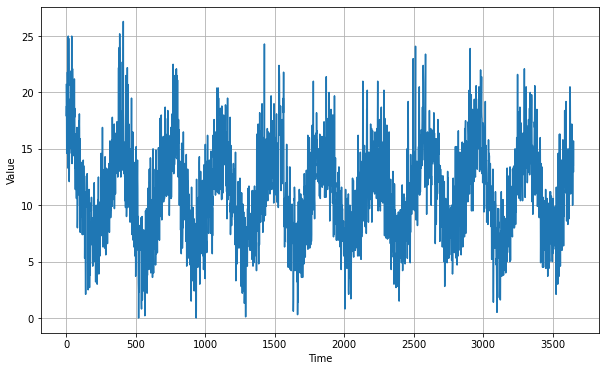

In [46]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)
  step=0
  for row in reader:
    step += 1
    time_step.append(step)
    temps.append(float(row[1]))

  

# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [47]:
split_time = 2500
time_train = time_step[:split_time]
x_train = temps[:split_time]
time_valid = time_step[split_time:]
x_valid = temps[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [48]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-1],window[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds



In [49]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)

  return forecast

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(train_set.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>


AttributeError: ignored

In [50]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu',
                         input_shape=[None,1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(30,activation='relu'),
  tf.keras.layers.Dense(15, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x *200)

])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>
Epoch 1/100
10/10 [==============================] - 3s 25ms/step - loss: 8.2114 - mae: 8.6987 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 8.0763 - mae: 8.5643 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 7.8850 - mae: 8.3722 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 31ms/step - loss: 7.6838 - mae: 8.1701 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 30ms/step - loss: 7.4797 - mae: 7.9672 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 7.2636 - mae: 7.7521 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 27ms/step - loss: 7.0288 - mae: 7.5185 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 6.7572 - mae: 7.2464 - lr: 2.2387e-08
Epoch 9/100
10/1

(1e-08, 0.0001, 0.0, 60.0)

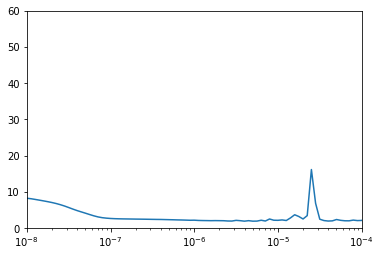

In [51]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [64]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                         input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64,return_sequences=True),
  tf.keras.layers.Dense(30,activation='relu'),
  tf.keras.layers.Dense(15, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x *400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/50
25/25 [==============================] - 3s 17ms/step - loss: 10.3475 - mae: 10.8312
Epoch 2/50
25/25 [==============================] - 1s 16ms/step - loss: 3.0790 - mae: 3.5467
Epoch 3/50
25/25 [==============================] - 1s 16ms/step - loss: 3.3994 - mae: 3.8743
Epoch 4/50
25/25 [==============================] - 1s 17ms/step - loss: 3.2929 - mae: 3.7654
Epoch 5/50
25/25 [==============================] - 1s 16ms/step - loss: 2.7522 - mae: 3.2168
Epoch 6/50
25/25 [==============================] - 1s 18ms/step - loss: 2.7721 - mae: 3.2396
Epoch 7/50
25/25 [==============================] - 1s 15ms/step - loss: 2.2990 - mae: 2.7588
Epoch 8/50
25/25 [==============================] - 1s 17ms/step - loss: 2.4592 - mae: 2.9211
Epoch 9/50
25/25 [==============================] - 1s 17ms/step - loss: 2.3793 - mae: 2.8407
Epoch 10/50
25/25 [==============================] - 1s 16ms/step - loss: 2.8976 - mae: 3.3688
Epoch 11/50
25/25 [==============================] - 1s 1

In [66]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast.shape

(3587, 64, 1)

In [67]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

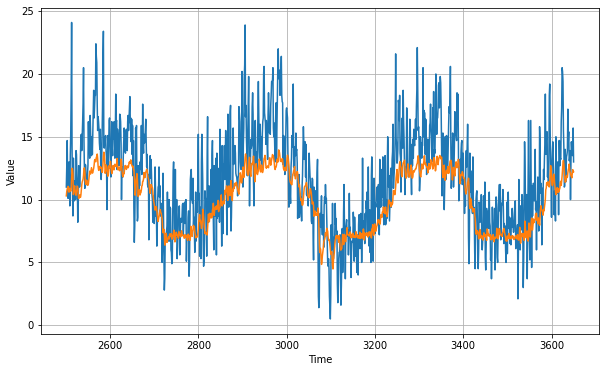

In [68]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [63]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

3.0691962

In [69]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[10.29792   10.647451  10.846461  ... 12.3850765 12.178453  12.209958 ]
